# **Excercise Sheet 2: Clustering**

# Part A: Foundations & Concepts

Before diving into the coding and implementation of clustering techniques, let's take a step back to understand the fundamental concepts and motivations behind these methods.

So please reflect on these questions independently first before consulting ChatGPT 😉 Feel free to discuss your thoughts with your classmates as well.

## 1. Clustering Principles

### **When do we use clustering?**

#### Your Answer:

#### Solution:
Clustering is used when we want to discover groups or patterns in data without knowing the group labels in advance. It helps find natural groupings, such as subgroups of patients with similar characteristics, groups of genes with related functions, or identifying new cancer subtypes for personalized treatment 

### **Why is clustering called an unsupervised learning method?**

#### Your Answer:

#### Solution:
Because we do not know the group labels in advance. Clustering algorithms work by finding patterns and structures in the data without any prior knowledge of the categories or classes.

### **How does K-Means clustering work?**
Briefly describe in your own words the different steps and what error you are trying to minimize.

#### Your Answer:

#### Solution:
K-Means clustering works by following these steps:
1. Define *k* number of clusters to be formed.
2. Randomly initialize *k* centroids (cluster centers).
3. Assign each data point to the nearest centroid based on a distance metric (usually Euclidean distance).
4. Compute the error as the sum of squared distances between each data point and its assigned centroid.
5. Update the centroids by calculating the mean of all data points assigned to each cluster.
6. Repeat steps 3-5 until convergence (i.e., centroids do not change significantly or assignments remain stable).

The algorithm tries to minimize the total within-cluster sum of squares (WCSS), which measures how close data points are to their cluster centroids. The goal is to minimize this error to achieve compact and well-separated clusters.

### **How does hierarchical clustering work?**

#### Your Answer:

#### Solution:
Hierarchical clustering works as follows:
1. Start with each data point as its own cluster.
2. Calculate the distance between all pairs of clusters using a distance metric (e.g., Euclidean distance).
3. Merge the two closest clusters to form a new cluster.
4. Repeat steps 2-3 until all data points are in a single cluster.
5. "Cut the tree" at a specific level to obtain the desired number of clusters.
    a. Look for jumps on y-axis (large distances indicate different clusters).
    b. Use Elbow plot to find the optimal number of clusters.


### **What is the advantage of the DBSCAN clustering algorithm?**

#### Your Answer:

#### Solution:
DBSCAN can find clusters of any shape and doesn’t need you to define how many clusters to look for. It also works well even if your data has noise or outliers. This makes it better than K-Means for messy or complex data. Note, k-means assume clusters to be spherical (“round”, like a ball). 

# Part B: Coding & Visualization

Time to apply what we've learned about clustering techniques! Let's start by importing the required libraries.

Hint:The Helper file contains functions that might assist you with some clustering tasks, however you're not obligated to use them. You can always develop your own implementations to accomplish the same objectives.

# Notes:
- Do we want to add a code cell about silhouette score? make a silhouette plot for best and second best k?
- Do we want to use the underlying groupings present in the data?
- for hierarhcical: The means show that the main differences between the clusters lie in the comorbidity_diabetes and comorbidity_hypertension. The clustering split the patients into four groups depending on the combination of these parameters!
- split up imports based on exercise?

In [38]:
# Imports
import numpy as np
import pandas as pd

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_samples
from helper import plot_elbow_method
from sklearn.decomposition import PCA
from umap import UMAP
from helper import plot_kmeans_clusters
from helper import plot_silhouette_scores
from scipy.cluster.hierarchy import linkage, fcluster

from helper import print_cluster_information_table, print_centroid_information
from helper import plot_hierarchical_clustering
from sklearn.cluster import AgglomerativeClustering
from gower import gower_matrix
from helper import plot_dbscan_grid, plot_k_distance_graph
from helper import plot_projection

import warnings
warnings.filterwarnings("ignore")

## 2. Clustering K-Means

### **Task: Data exploration**

This clinical dataset contains biomarker measurements from 300 patients with a chronic inflammatory condition, collected during routine clinical assessments. The measurements include inflammatory markers, blood parameters, metabolic indicators, cardiovascular measures, and patient demographics that physicians commonly use to assess patient health status and disease progression.

- Load and inspect the dataset `data_todo.csv`.
- What variables do you have?

#### Your Answer:

In [39]:
# Student Code

#### Solution:

In [40]:
# Simulate Data
def create_clinical_dataset(n_patients=300):
    """
    Create a clinical dataset with continuous biomarker measurements
    from patients with different disease subtypes
    """
    
    # Define 3 patient subgroups with different clinical profiles
    n_per_group = n_patients // 3
    
    # Subgroup 1: Mild inflammatory profile
    group1 = np.random.multivariate_normal(
        mean=[2.1, 45, 6.8, 120, 22, 3.2, 1.8, 95, 38, 5.5],
        cov=np.diag([0.3, 25, 0.4, 100, 4, 0.5, 0.3, 36, 16, 0.8]),
        size=n_per_group
    )
    
    # Subgroup 2: Severe inflammatory profile
    group2 = np.random.multivariate_normal(
        mean=[8.5, 65, 4.2, 160, 28, 6.8, 4.2, 75, 22, 8.2],
        cov=np.diag([1.2, 36, 0.6, 144, 9, 1.0, 0.8, 49, 25, 1.5]),
        size=n_per_group
    )
    
    # Subgroup 3: Metabolic dysfunction profile
    group3 = np.random.multivariate_normal(
        mean=[5.2, 55, 9.5, 95, 35, 2.8, 2.5, 110, 45, 3.8],
        cov=np.diag([0.8, 30, 1.2, 81, 16, 0.4, 0.6, 64, 36, 0.9]),
        size=n_per_group
    )
    
    # Combine all groups
    data = np.vstack([group1, group2, group3])
    
    # Add some noise to make it more realistic
    noise = np.random.normal(0, 0.1, data.shape)
    data = data + noise
    
    # Create true cluster labels for validation (not to be used in clustering)
    true_labels = np.array([0]*n_per_group + [1]*n_per_group + [2]*n_per_group)
    
    # Randomize the order of patients
    random_indices = np.random.permutation(len(data))
    data = data[random_indices]
    true_labels = true_labels[random_indices]
    
    # Create DataFrame with meaningful clinical variable names
    columns = [
        'CRP_mg_L',           # C-reactive protein (inflammation marker)
        'ESR_mm_hr',          # Erythrocyte sedimentation rate
        'Hemoglobin_g_dL',    # Hemoglobin levels
        'Platelets_K_uL',     # Platelet count
        'BMI',                # Body mass index
        'Glucose_mmol_L',     # Blood glucose
        'Cholesterol_mmol_L', # Total cholesterol
        'Systolic_BP',        # Systolic blood pressure
        'Age_years',          # Patient age
        'Disease_duration_years' # Years since diagnosis
    ]
    
    df = pd.DataFrame(data, columns=columns)
    
    # Ensure all values are positive and realistic
    df['CRP_mg_L'] = np.abs(df['CRP_mg_L'])
    df['ESR_mm_hr'] = np.abs(df['ESR_mm_hr'])
    df['Hemoglobin_g_dL'] = np.abs(df['Hemoglobin_g_dL'])
    df['Platelets_K_uL'] = np.abs(df['Platelets_K_uL'])
    df['BMI'] = np.abs(df['BMI'])
    df['Glucose_mmol_L'] = np.abs(df['Glucose_mmol_L'])
    df['Cholesterol_mmol_L'] = np.abs(df['Cholesterol_mmol_L'])
    df['Systolic_BP'] = np.abs(df['Systolic_BP'])
    df['Age_years'] = np.abs(df['Age_years'])
    df['Disease_duration_years'] = np.abs(df['Disease_duration_years'])
    
    return df, true_labels

# Create the dataset
clinical_data, true_labels = create_clinical_dataset(n_patients=300)

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Shape: {clinical_data.shape}")
print(f"Number of patients: {clinical_data.shape[0]}")
print(f"Number of clinical variables: {clinical_data.shape[1]}")
print("\nVariable types:")
print(clinical_data.dtypes)
print("\nFirst few rows:")
print(clinical_data.head())

# Display summary statistics
print("\nSummary Statistics:")

Dataset Overview:
Shape: (300, 10)
Number of patients: 300
Number of clinical variables: 10

Variable types:
CRP_mg_L                  float64
ESR_mm_hr                 float64
Hemoglobin_g_dL           float64
Platelets_K_uL            float64
BMI                       float64
Glucose_mmol_L            float64
Cholesterol_mmol_L        float64
Systolic_BP               float64
Age_years                 float64
Disease_duration_years    float64
dtype: object

First few rows:
   CRP_mg_L  ESR_mm_hr  Hemoglobin_g_dL  Platelets_K_uL        BMI  \
0  6.125899  49.176299         7.868722      100.023846  33.383823   
1  2.146168  40.991777         6.733638      133.336348  19.920253   
2  8.780586  58.984997         4.530781      175.446506  34.437055   
3  8.825106  58.321085         3.588363      143.250558  24.643468   
4  7.234942  64.532818         4.513644      147.017344  30.306747   

   Glucose_mmol_L  Cholesterol_mmol_L  Systolic_BP  Age_years  \
0        3.331966            0.942

In [41]:
# Load data
df = clinical_data

In [42]:
print(df.shape)
print(df.head())

(300, 10)
   CRP_mg_L  ESR_mm_hr  Hemoglobin_g_dL  Platelets_K_uL        BMI  \
0  6.125899  49.176299         7.868722      100.023846  33.383823   
1  2.146168  40.991777         6.733638      133.336348  19.920253   
2  8.780586  58.984997         4.530781      175.446506  34.437055   
3  8.825106  58.321085         3.588363      143.250558  24.643468   
4  7.234942  64.532818         4.513644      147.017344  30.306747   

   Glucose_mmol_L  Cholesterol_mmol_L  Systolic_BP  Age_years  \
0        3.331966            0.942153   106.358231  54.528258   
1        3.435767            1.093000    92.335739  40.859346   
2        7.447837            6.503653    83.065796  12.674891   
3        6.488235            4.639700    73.724674  18.623153   
4        7.416095            5.650290    75.312516  30.966452   

   Disease_duration_years  
0                4.022359  
1                4.828238  
2                7.419409  
3                7.403166  
4                8.039567  


In [43]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['CRP_mg_L', 'ESR_mm_hr', 'Hemoglobin_g_dL', 'Platelets_K_uL', 'BMI', 'Glucose_mmol_L', 'Cholesterol_mmol_L', 'Systolic_BP', 'Age_years', 'Disease_duration_years']


In [44]:
# Check for categorical features and their values
print("Data types:")
print(df.dtypes)
print()

Data types:
CRP_mg_L                  float64
ESR_mm_hr                 float64
Hemoglobin_g_dL           float64
Platelets_K_uL            float64
BMI                       float64
Glucose_mmol_L            float64
Cholesterol_mmol_L        float64
Systolic_BP               float64
Age_years                 float64
Disease_duration_years    float64
dtype: object



In [45]:
# Prepare dataset for later analysis
scaler = StandardScaler()
X = scaler.fit_transform(df)

### **Task: Perform K-Means clustering**
- Perform K-Means clustering on the dataset.

#### Your Answer:

In [46]:
# Student Code

#### Solution:

In [47]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_centroids = kmeans.cluster_centers_

- Now let's analyze the Elbow plot. What is the optimal number of clusters? Why?

#### Your Answer:

In [48]:
# Student Code

#### Solution:

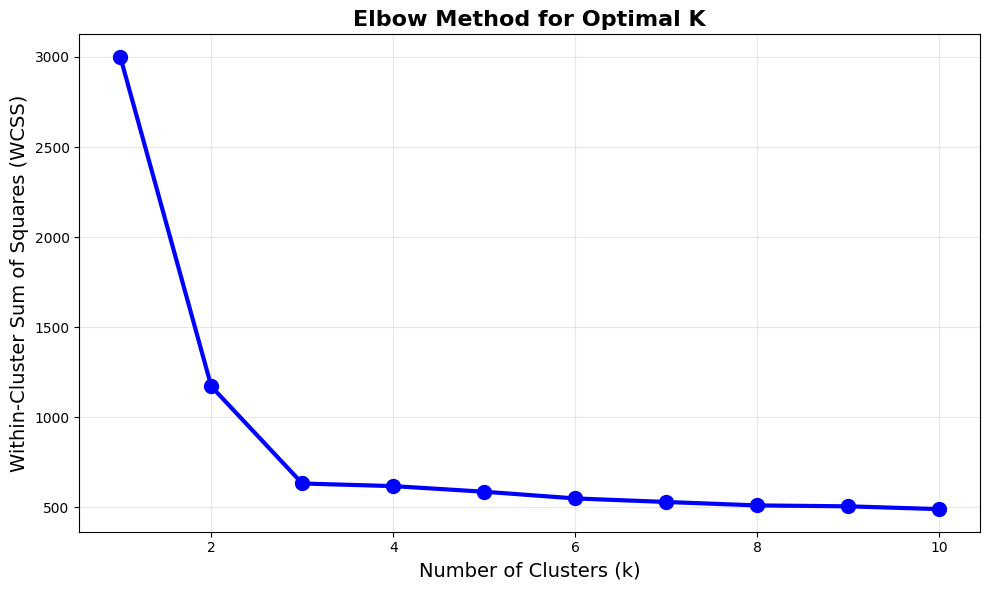

In [49]:
# Elbow Method for optimal k
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(X)
    wcss.append(kmeans_temp.inertia_)

plot_elbow_method(k_range, wcss)

The optimal number of clusters is 3, as indicated by the "elbow" in the plot.

- Finally let's visualize the clusters using PCA or UMAP.

#### Your Answer:

In [50]:
# Student Code

#### Solution:

In [51]:
# Option A: Fit PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
centroids_reduced = pca.transform(kmeans_centroids)
title = "PCA Visualization of K-Means Clusters"

In [52]:
# Option B: Fit UMAP
umap = UMAP(n_components=2, random_state=42)
X_reduced = umap.fit_transform(X)
centroids_reduced = umap.transform(kmeans_centroids)
title = "UMAP Visualization of K-Means Clusters"

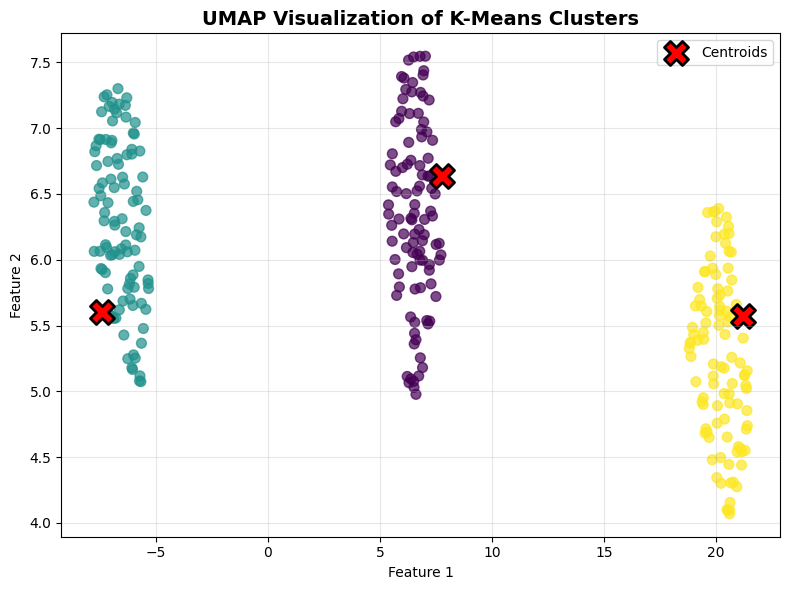

In [53]:
# Visualize 
plot_kmeans_clusters(X_reduced, kmeans_labels, centroids=centroids_reduced, title=title)

- Let's calculate the silhouette score for the best k and the second best k, and visualize it using the reduced data.

#### Your Answer:

In [54]:
# Code

#### Solution:

In [55]:
# Calculate silhouette scores for 3 clusters
silhouette_scores = silhouette_score(X, kmeans_labels)
sample_silhouette_values = silhouette_samples(X, kmeans_labels)

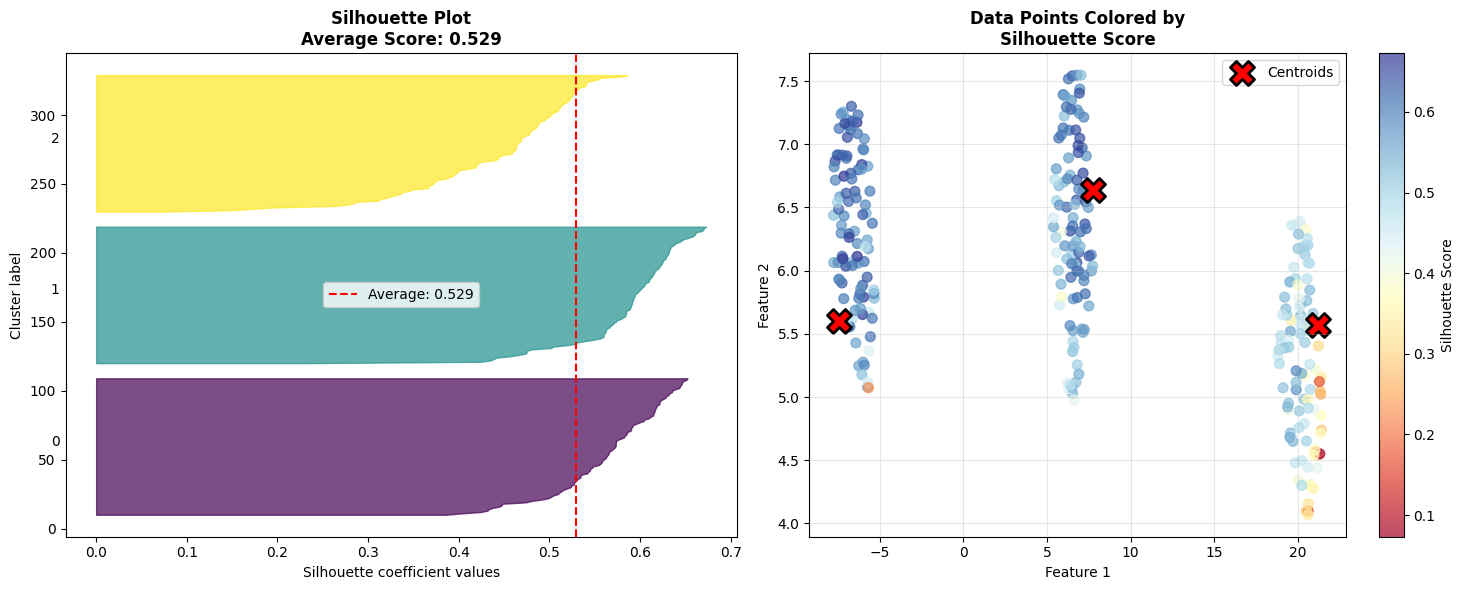

In [56]:
# Plot silhouette scores
plot_silhouette_scores(X_reduced, kmeans_labels, centroids_reduced, silhouette_scores, sample_silhouette_values)

In [57]:
# Fit KMeans with 4 clusters TODO: Adjust to PCA depending on option A or B
four_kmeans = KMeans(n_clusters=4, random_state=42)
four_means_labels = four_kmeans.fit_predict(X)
four_means_centroids = umap.transform(four_kmeans.cluster_centers_)

In [58]:
# Recalculate silhouette score for 4 clusters
silhouette_scores = silhouette_score(X, four_means_labels)
sample_silhouette_values = silhouette_samples(X, four_means_labels)

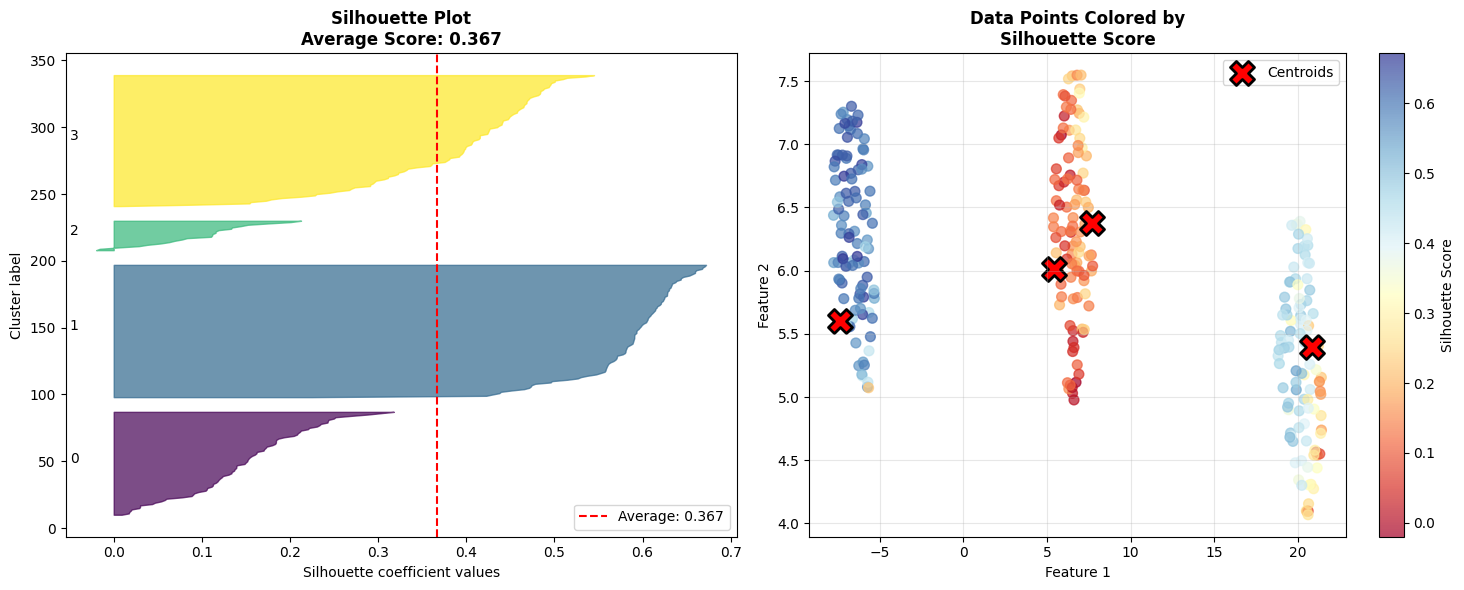

In [59]:
# Plot silhouette scores for 4 clusters
plot_silhouette_scores(X_reduced, four_means_labels, four_means_centroids, silhouette_scores, sample_silhouette_values)

- Extract the centroids for each cluster and interpret their mean values. What do these mean values tell you about the clusters?

#### Your Answer:

In [60]:
# Student Code

#### Solution:

In [61]:

# TODO: Add this function to handson such that students know what to do

print_centroid_information(df, kmeans_centroids, scaler)

                         Cluster 0   Cluster 1   Cluster 2
CRP_mg_L                  2.098261    8.641342    5.217653
ESR_mm_hr                45.426467   64.877761   54.607276
Hemoglobin_g_dL           6.838127    4.287305    9.341602
Platelets_K_uL          120.259745  161.383289   95.329401
BMI                      21.960186   28.117927   34.498303
Glucose_mmol_L            3.103735    6.662053    2.905166
Cholesterol_mmol_L        1.787543    4.419050    2.413665
Systolic_BP              95.175257   74.751818  109.979011
Age_years                38.117880   22.135052   45.243174
Disease_duration_years    5.542230    8.284511    3.555498


- What do you conclude? Did the clustering work well? Why or why not?

#### Your Answer:

#### Solution:
- Elbow plot shows a clear "elbow" at k=3, indicating that 3 clusters is optimal.
- PCA/UMAP visualization shows distinct clusters, suggesting that K-Means clustering effectively separated the patients into meaningful groups based on their biomarker measurements.
- The centroids reveal three distinct patient subgroups: one with high BMI, BP in older patients, another with high CRP, ESR with comorbidities, and a last one (well-controlled markers).
- TODO add something to silhouette once fixed

## 3. Hierarchical Clustering

Open: I'm not sure if it makes sense to perform K-means first and then it doesn't work? Let's just use hierarchical clustering and we see it doesn't work and then we do gower distance?


TODO: Info about dataset:
This clinical dataset contains 200 patients with a chronic condition, featuring both continuous biomarkers (age, BMI, blood pressure, creatinine, hemoglobin) and categorical clinical variables (disease severity, comorbidities, treatment response, smoking status, NYHA functional class). The dataset includes realistic clinical noise and heterogeneity, with categorical variables having multiple levels (not just binary) to reflect real-world clinical complexity.

Numeric variables: Age, BMI, Systolic_BP, Creatinine, Hemoglobin
Categorical variables: Disease_severity (3 levels), Comorbidity_diabetes (2 levels), Comorbidity_hypertension (2 levels), Treatment_response (3 levels), Smoking_status (3 levels), NYHA_class (4 levels)
Built-in noise: 10% noise added to numeric variables, 5% random flips in categorical variables
Three underlying patient subgroups: Elderly cardiovascular, middle-aged metabolic, younger inflammatory profiles

### **Task: Data exploration**
- Load and inspect the dataset `data_todo.csv`.
- How many variables do you have?
- What types of features ("predictors") and targets ("outcomes") do you have? Note, technically we don't have a target here. But 
- Do you have categorical features? Are they coded as such?

In [62]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def create_mixed_clinical_dataset(n_patients=200):
    """
    Create a mixed clinical dataset with numeric and categorical variables
    Contains noise and realistic clinical heterogeneity
    """
    np.random.seed(42)
    
    # Define 3 patient subgroups
    n_per_group = n_patients // 3
    
    # Initialize lists to store data
    data = []
    true_labels = []
    
    # Group 1: Elderly with cardiovascular complications
    for i in range(n_per_group):
        patient = {
            'Age': np.random.normal(70, 8),
            'BMI': np.random.normal(28, 4),
            'Systolic_BP': np.random.normal(145, 15),
            'Creatinine': np.random.normal(1.4, 0.3),
            'Hemoglobin': np.random.normal(11.5, 1.2),
            'Disease_severity': np.random.choice(['Mild', 'Moderate', 'Severe'], p=[0.2, 0.5, 0.3]),
            'Comorbidity_diabetes': np.random.choice(['Yes', 'No'], p=[0.6, 0.4]),
            'Comorbidity_hypertension': np.random.choice(['Yes', 'No'], p=[0.8, 0.2]),
            'Treatment_response': np.random.choice(['Poor', 'Moderate', 'Good'], p=[0.5, 0.3, 0.2]),
            'Smoking_status': np.random.choice(['Never', 'Former', 'Current'], p=[0.3, 0.5, 0.2]),
            'NYHA_class': np.random.choice(['I', 'II', 'III', 'IV'], p=[0.1, 0.3, 0.4, 0.2])
        }
        data.append(patient)
        true_labels.append(0)
    
    # Group 2: Middle-aged with metabolic syndrome
    for i in range(n_per_group):
        patient = {
            'Age': np.random.normal(55, 10),
            'BMI': np.random.normal(32, 5),
            'Systolic_BP': np.random.normal(135, 12),
            'Creatinine': np.random.normal(1.1, 0.2),
            'Hemoglobin': np.random.normal(13.2, 1.0),
            'Disease_severity': np.random.choice(['Mild', 'Moderate', 'Severe'], p=[0.4, 0.4, 0.2]),
            'Comorbidity_diabetes': np.random.choice(['Yes', 'No'], p=[0.7, 0.3]),
            'Comorbidity_hypertension': np.random.choice(['Yes', 'No'], p=[0.6, 0.4]),
            'Treatment_response': np.random.choice(['Poor', 'Moderate', 'Good'], p=[0.3, 0.4, 0.3]),
            'Smoking_status': np.random.choice(['Never', 'Former', 'Current'], p=[0.4, 0.3, 0.3]),
            'NYHA_class': np.random.choice(['I', 'II', 'III', 'IV'], p=[0.4, 0.4, 0.2, 0.0])
        }
        data.append(patient)
        true_labels.append(1)
    
    # Group 3: Younger patients with inflammatory profile
    for i in range(n_per_group):
        patient = {
            'Age': np.random.normal(42, 12),
            'BMI': np.random.normal(24, 3),
            'Systolic_BP': np.random.normal(125, 10),
            'Creatinine': np.random.normal(0.9, 0.15),
            'Hemoglobin': np.random.normal(12.8, 1.1),
            'Disease_severity': np.random.choice(['Mild', 'Moderate', 'Severe'], p=[0.3, 0.4, 0.3]),
            'Comorbidity_diabetes': np.random.choice(['Yes', 'No'], p=[0.2, 0.8]),
            'Comorbidity_hypertension': np.random.choice(['Yes', 'No'], p=[0.3, 0.7]),
            'Treatment_response': np.random.choice(['Poor', 'Moderate', 'Good'], p=[0.2, 0.3, 0.5]),
            'Smoking_status': np.random.choice(['Never', 'Former', 'Current'], p=[0.6, 0.2, 0.2]),
            'NYHA_class': np.random.choice(['I', 'II', 'III', 'IV'], p=[0.6, 0.3, 0.1, 0.0])
        }
        data.append(patient)
        true_labels.append(2)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add noise to numeric variables
    numeric_cols = ['Age', 'BMI', 'Systolic_BP', 'Creatinine', 'Hemoglobin']
    for col in numeric_cols:
        noise = np.random.normal(0, df[col].std() * 0.1, len(df))
        df[col] = df[col] + noise
    
    # Add some random categorical noise (flip some values)
    categorical_cols = ['Disease_severity', 'Comorbidity_diabetes', 'Comorbidity_hypertension', 
                       'Treatment_response', 'Smoking_status', 'NYHA_class']
    for col in categorical_cols:
        # Randomly flip 5% of values
        flip_indices = np.random.choice(len(df), size=int(0.05 * len(df)), replace=False)
        unique_values = df[col].unique()
        for idx in flip_indices:
            current_val = df.loc[idx, col]
            new_val = np.random.choice([v for v in unique_values if v != current_val])
            df.loc[idx, col] = new_val
    
    # Ensure positive values for certain variables
    df['Age'] = np.abs(df['Age'])
    df['BMI'] = np.abs(df['BMI'])
    df['Systolic_BP'] = np.abs(df['Systolic_BP'])
    df['Creatinine'] = np.abs(df['Creatinine'])
    df['Hemoglobin'] = np.abs(df['Hemoglobin'])
    
    # Convert categorical variables to proper categorical dtype
    for col in categorical_cols:
        df[col] = df[col]#.astype('category')
    
    # Randomize order
    random_indices = np.random.permutation(len(df))
    df = df.iloc[random_indices].reset_index(drop=True)
    true_labels = np.array(true_labels)[random_indices]
    
    return df, true_labels

# Create the dataset
df, true_labels = create_mixed_clinical_dataset(200)

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nFirst few rows:")
print(df.head())

print("\nCategorical Variables Summary:")
categorical_cols = df.select_dtypes(include=['category']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].value_counts().to_dict()}")


Dataset Shape: (198, 11)

Data Types:
Age                         float64
BMI                         float64
Systolic_BP                 float64
Creatinine                  float64
Hemoglobin                  float64
Disease_severity             object
Comorbidity_diabetes         object
Comorbidity_hypertension     object
Treatment_response           object
Smoking_status               object
NYHA_class                   object
dtype: object

First few rows:
         Age        BMI  Systolic_BP  Creatinine  Hemoglobin Disease_severity  \
0  20.683679  22.448353   150.961756    0.842703   13.030787         Moderate   
1  62.710404  33.687275   166.105799    0.965958   12.624673             Mild   
2  57.348697  28.877922   137.375014    1.221770   13.242701             Mild   
3  53.058541  21.662985   109.538620    1.113346   12.472358         Moderate   
4  56.632266  24.327240   148.541490    1.390223   10.239944           Severe   

  Comorbidity_diabetes Comorbidity_hypertension 

#### Your Answer:

In [63]:
# Student Code

#### Solution:

In [64]:
# Load Data
# df = pd.read_csv('todo.csv') 

In [65]:
# Inspect data
print(df.shape)
print(df.head())

(198, 11)
         Age        BMI  Systolic_BP  Creatinine  Hemoglobin Disease_severity  \
0  20.683679  22.448353   150.961756    0.842703   13.030787         Moderate   
1  62.710404  33.687275   166.105799    0.965958   12.624673             Mild   
2  57.348697  28.877922   137.375014    1.221770   13.242701             Mild   
3  53.058541  21.662985   109.538620    1.113346   12.472358         Moderate   
4  56.632266  24.327240   148.541490    1.390223   10.239944           Severe   

  Comorbidity_diabetes Comorbidity_hypertension Treatment_response  \
0                   No                       No               Good   
1                  Yes                       No           Moderate   
2                  Yes                       No           Moderate   
3                   No                       No               Good   
4                   No                      Yes           Moderate   

  Smoking_status NYHA_class  
0         Former         II  
1          Never      

In [66]:
# Check the features
print("Features:")
print(df.columns.tolist())

Features:
['Age', 'BMI', 'Systolic_BP', 'Creatinine', 'Hemoglobin', 'Disease_severity', 'Comorbidity_diabetes', 'Comorbidity_hypertension', 'Treatment_response', 'Smoking_status', 'NYHA_class']


In [67]:
# Check for categorical features
print("Data types:")
print(df.dtypes)


Data types:
Age                         float64
BMI                         float64
Systolic_BP                 float64
Creatinine                  float64
Hemoglobin                  float64
Disease_severity             object
Comorbidity_diabetes         object
Comorbidity_hypertension     object
Treatment_response           object
Smoking_status               object
NYHA_class                   object
dtype: object


In [68]:
# for each categorical feature, print the unique values
# TODO: Mabye we can make this more beautiful
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")

Disease_severity: [np.str_('Moderate') np.str_('Mild') np.str_('Severe')]
Comorbidity_diabetes: [np.str_('No') np.str_('Yes')]
Comorbidity_hypertension: [np.str_('No') np.str_('Yes')]
Treatment_response: [np.str_('Good') np.str_('Moderate') np.str_('Poor')]
Smoking_status: [np.str_('Former') np.str_('Never') np.str_('Current')]
NYHA_class: [np.str_('II') np.str_('III') np.str_('I') np.str_('IV')]


In [69]:
# Prepare dataset for later analysis
X = df

Note: I changed it to performing hierarchical clustering.

### **Task: Perform Hierarchical clustering**
- Perform Hierarchical clustering on the dataset. If you encounter an error what could be the reason? How can you fix it?

#### Your Answer:

In [70]:
# Student Code

#### Solution:

In [71]:
# Perfrom Hierarchical clustering
try:
    # Attempt to perform hierarchical clustering
    hier_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
    hier_labels = hier_model.fit_predict(X)
except ValueError as e:
    print(f"Error: {e}")
    print("Hierarchical clustering requires numerical data. Consider encoding categorical variables or using a distance metric that supports mixed data types.")

Error: could not convert string to float: np.str_('Moderate')
Hierarchical clustering requires numerical data. Consider encoding categorical variables or using a distance metric that supports mixed data types.


- To include the categorical data, we can compute Gower distance and perform the clustering on the resulting distance matrix. First compute the Gower distance matrix.

In [72]:
# Student Code

In [73]:
# Compute gower
# Compute Gower distance matrix
# TODO: Maybe scale data before
gower_dist = gower_matrix(X)

- Perfect now let's visualize the dendrogram. What do you observe? What does the y-axis represent? How can you use it to determine the number of clusters?

In [74]:
# Student Code

In [75]:
# Solution

# Create linkage matrix using Ward Linkage method
linkage_matrix_gower = linkage(gower_dist, method='ward')
cluster_labels_gower = fcluster(linkage_matrix_gower, 3, criterion='maxclust') - 1

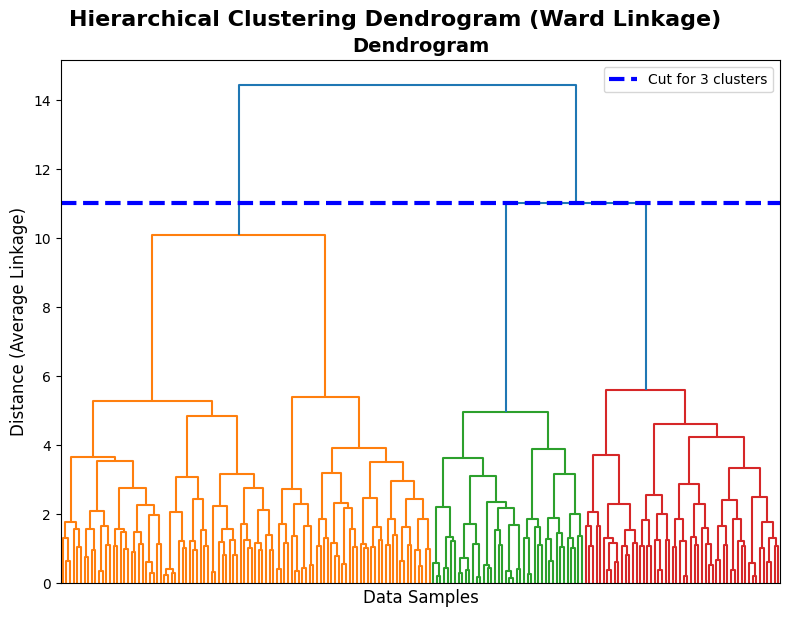

In [76]:
# Plot the dendrogram
plot_hierarchical_clustering(X, linkage_matrix_gower, cluster_labels_gower, title="Hierarchical Clustering Dendrogram (Ward Linkage)")

We observe that we have 2 larger groups, which split into two more smaller groups. The y-axis represents the distance between clusters, which can be used to determine the number of clusters by looking for jumps in the distance values. Therefore it looks like suitable values would be 2 or 4 clusters.

- Now let's visualize the data using PCA or UMAP. Choose the number of clusters based on the dendrogram.

In [77]:
# Perform clustering on Gower distance matrix using `AgglomerativeClustering` for just labels
# TODO: If we use gower distance matrix, we can set metric precomputed because we have pairwise distances already

n_cluster = 2  # Adjust this based on the dendrogram, also reasonable 4
hier_gower = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward')
hier_gower_labels = hier_gower.fit_predict(gower_dist)

In [78]:
# Calculate cluster assignments

n_cluster = 4
cluster_labels_gower = fcluster(linkage_matrix_gower, n_cluster, criterion='maxclust') - 1

In [79]:
# Reduce dimensions for visualization
# Option A: Fit PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(gower_dist)

# Option B: Fit UMAP
#umap = UMAP(n_components=2, random_state=42)
#X_reduced = umap.fit_transform(gower_dist)

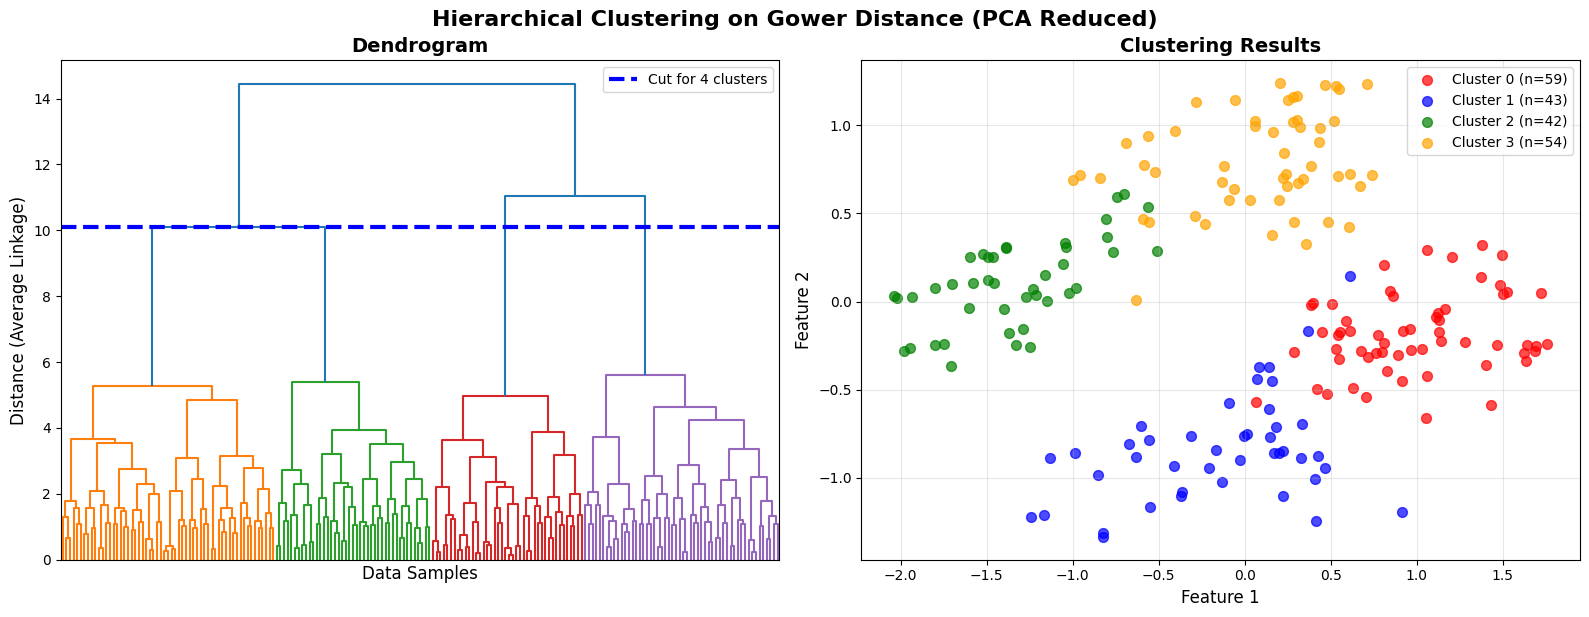

In [80]:
# Plot 
plot_hierarchical_clustering(X_reduced, linkage_matrix_gower, cluster_labels_gower, title="Hierarchical Clustering on Gower Distance (PCA Reduced)")

- Are the clusters of patient subpopulations visible? How are they characterized? 

*Hint:* Calculate the mean of features per cluster and interpret the results.

In [81]:
# Student Code and Answer

In [82]:
# Usage example:
print_cluster_information_table(df, cluster_labels_gower)

Cluster Characteristics:
Numeric: mean values | Categorical: mode (count/total, %)
                                        Cluster 0                Cluster 1  \
Age                                         62.47                    55.54   
BMI                                         28.53                    28.52   
Systolic_BP                                139.32                   134.82   
Creatinine                                   1.27                     1.11   
Hemoglobin                                  12.27                    12.73   
Disease_severity          Moderate (26/59, 44.1%)  Moderate (19/43, 44.2%)   
Comorbidity_diabetes          Yes (59/59, 100.0%)      Yes (43/43, 100.0%)   
Comorbidity_hypertension      Yes (59/59, 100.0%)        No (41/43, 95.3%)   
Treatment_response            Poor (27/59, 45.8%)  Moderate (17/43, 39.5%)   
Smoking_status               Never (24/59, 40.7%)     Never (16/43, 37.2%)   
NYHA_class                      II (20/59, 33.9%)        II

- We see 2 or 4 cluster solutions in the dendrogram
- These clusters are clearly seperable with UMAP and somewhat seperable with PCA
- The means show that the main differences between the clusters lie in the comorbidity_diabetes and comorbidity_hypertension. The clustering split the patients into four groups depending on the combination of these parameters!

## 4. DBSCAN Clustering

### **Task: Data exploration**
- Load and inspect the dataset `data_todo.csv`.
- What types of features ("predictors") and targets ("outcomes") do you have?

In [83]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def create_complex_clinical_dataset(n_patients=400):
    """
    Create a clinical dataset with complex, non-linear relationships
    Simulates realistic clinical scenarios where patient subgroups
    form non-convex clusters that K-means would struggle with
    """
    np.random.seed(42)
    
    # Create base patterns using sklearn's datasets
    n_per_pattern = n_patients // 4
    
    # Pattern 1: Two crescent-shaped groups (e.g., treatment response vs biomarker)
    moons_data, _ = make_moons(n_samples=n_per_pattern, noise=0.15, random_state=42)
    
    # Pattern 2: Circular pattern (e.g., metabolic syndrome with central obesity)
    circles_data, _ = make_circles(n_samples=n_per_pattern, noise=0.1, factor=0.4, random_state=42)
    
    # Pattern 3: Dense blob (e.g., normal healthy controls)
    blob_data, _ = make_blobs(n_samples=n_per_pattern, centers=1, n_features=2, 
                             cluster_std=0.3, random_state=42)
    
    # Pattern 4: Elongated cluster (e.g., progressive disease trajectory)
    elongated_x = np.random.normal(0, 2, n_per_pattern)
    elongated_y = elongated_x * 0.5 + np.random.normal(0, 0.3, n_per_pattern)
    elongated_data = np.column_stack([elongated_x, elongated_y])
    
    # Combine all patterns and transform to clinical meaningful ranges
    all_data = np.vstack([moons_data, circles_data, blob_data, elongated_data])
    
    # Transform to clinical ranges and add more features
    # Feature 1: Inflammatory marker (CRP-like)
    crp_like = all_data[:, 0] * 15 + 25  # Range ~10-40 mg/L
    crp_like = np.maximum(crp_like, 0.1)  # Ensure positive
    
    # Feature 2: Metabolic marker (Glucose-like)
    glucose_like = all_data[:, 1] * 20 + 100  # Range ~80-120 mg/dL
    glucose_like = np.maximum(glucose_like, 60)  # Ensure realistic minimum
    
    # Feature 3: Cardiac marker (derived from both patterns)
    cardiac_marker = (all_data[:, 0] * all_data[:, 1]) * 10 + 15
    cardiac_marker += np.random.normal(0, 2, len(cardiac_marker))  # Add noise
    
    # Feature 4: Renal function (non-linear relationship)
    renal_function = np.sin(all_data[:, 0] * 2) * 0.5 + all_data[:, 1] * 0.3 + 1.2
    renal_function += np.random.normal(0, 0.1, len(renal_function))
    renal_function = np.maximum(renal_function, 0.5)  # Ensure positive
    
    # Feature 5: Age-related biomarker
    age_biomarker = np.sqrt(np.abs(all_data[:, 0])) * 10 + np.abs(all_data[:, 1]) * 5 + 45
    age_biomarker += np.random.normal(0, 3, len(age_biomarker))
    age_biomarker = np.maximum(age_biomarker, 20)  # Ensure realistic minimum
    
    # Feature 6: Lipid profile (complex interaction)
    lipid_profile = (all_data[:, 0]**2 + all_data[:, 1]**2) * 30 + 150
    lipid_profile += np.random.normal(0, 10, len(lipid_profile))
    lipid_profile = np.maximum(lipid_profile, 100)  # Ensure realistic minimum
    
    # Add additional noise and outliers
    n_outliers = int(0.05 * n_patients)  # 5% outliers
    outlier_indices = np.random.choice(len(all_data), size=n_outliers, replace=False)
    
    # Create extreme outliers
    for idx in outlier_indices:
        crp_like[idx] *= np.random.uniform(2, 4)
        glucose_like[idx] *= np.random.uniform(1.5, 2.5)
        cardiac_marker[idx] *= np.random.uniform(2, 3)
    
    # Create DataFrame
    df = pd.DataFrame({
        'Inflammatory_Marker_CRP': crp_like,
        'Metabolic_Glucose': glucose_like,
        'Cardiac_Troponin': cardiac_marker,
        'Renal_Creatinine': renal_function,
        'Age_Related_Biomarker': age_biomarker,
        'Lipid_Cholesterol': lipid_profile
    })
    
    # Add more complex noise patterns
    # Introduce missing value patterns (fill with median for clustering)
    missing_indices = np.random.choice(len(df), size=int(0.02 * len(df)), replace=False)
    for idx in missing_indices:
        col = np.random.choice(df.columns)
        df.loc[idx, col] = np.nan
    
    # Fill missing values with median
    df = df.fillna(df.median())
    
    # Add measurement noise (clinical lab variation)
    for col in df.columns:
        measurement_noise = np.random.normal(0, df[col].std() * 0.05, len(df))
        df[col] = df[col] + measurement_noise
    
    # Randomize order
    random_indices = np.random.permutation(len(df))
    df = df.iloc[random_indices].reset_index(drop=True)
    
    # Create true cluster labels based on original patterns (for validation)
    true_labels = np.array([0]*n_per_pattern + [1]*n_per_pattern + 
                          [2]*n_per_pattern + [3]*n_per_pattern)
    true_labels = true_labels[random_indices]
    
    return df, true_labels

# Create the dataset
df, true_labels = create_complex_clinical_dataset(400)

# Display dataset info
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)
print("\nDataset Description:")
print(df.describe())

print("\nFirst few rows:")
print(df.head(10))

print("\nDataset Info:")
print(f"Number of variables: {df.shape[1]}")
print(f"Number of patients: {df.shape[0]}")
print(f"All features are numerical (continuous biomarkers)")

# Visualize the complex relationships
#fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()

# # Plot pairwise relationships to show complexity
# feature_pairs = [
#     ('Inflammatory_Marker_CRP', 'Metabolic_Glucose'),
#     ('Cardiac_Troponin', 'Renal_Creatinine'),
#     ('Age_Related_Biomarker', 'Lipid_Cholesterol'),
#     ('Inflammatory_Marker_CRP', 'Cardiac_Troponin'),
#     ('Metabolic_Glucose', 'Renal_Creatinine'),
#     ('Age_Related_Biomarker', 'Inflammatory_Marker_CRP')
# ]

# for i, (x_col, y_col) in enumerate(feature_pairs):
#     axes[i].scatter(df[x_col], df[y_col], alpha=0.6, s=30)
#     axes[i].set_xlabel(x_col)
#     axes[i].set_ylabel(y_col)
#     axes[i].set_title(f'{x_col} vs {y_col}')

# plt.tight_layout()
#plt.show()

# Show correlation matrix
#plt.figure(figsize=(10, 8))
# correlation_matrix = df.corr()
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
# plt.title('Correlation Matrix of Clinical Biomarkers')
#plt.show()

Dataset Shape: (400, 6)

Data Types:
Inflammatory_Marker_CRP    float64
Metabolic_Glucose          float64
Cardiac_Troponin           float64
Renal_Creatinine           float64
Age_Related_Biomarker      float64
Lipid_Cholesterol          float64
dtype: object

Dataset Description:
       Inflammatory_Marker_CRP  Metabolic_Glucose  Cardiac_Troponin  \
count               400.000000         400.000000        400.000000   
mean                 22.492400         154.442979        -44.051864   
std                  22.300357          96.735180        124.011879   
min                  -2.970596          54.579204       -676.123903   
25%                   1.122041          95.213779        -40.727515   
50%                  21.092132         108.998225         13.922775   
75%                  34.152406         255.124573         22.892000   
max                 191.076954         673.792046        153.731514   

       Renal_Creatinine  Age_Related_Biomarker  Lipid_Cholesterol  
count    

#### Your Answer:

#### Solution:


In [84]:
# Load Data
# df = pd.read_csv('todo.csv')


In [85]:
# Inspect data
print(df.shape)
df.head()

(400, 6)


,Inflammatory_Marker_CRP,Metabolic_Glucose,Cardiac_Troponin,Renal_Creatinine,Age_Related_Biomarker,Lipid_Cholesterol
0,0.448688,270.542398,-199.674966,4.384544,102.874330,2628.311719
1,-0.753005,275.015923,-196.373513,4.262268,104.209996,2456.276485
2,45.368262,90.415441,13.537962,1.200815,65.898116,133.588322
3,-0.284114,278.002857,-201.059251,4.233666,103.833760,2770.340266
4,-0.523356,652.534260,-563.873730,4.465646,104.970987,3030.463463


In [86]:
# Check the features and outcomes
print("Features:")
print(df.columns.tolist())

Features:
['Inflammatory_Marker_CRP', 'Metabolic_Glucose', 'Cardiac_Troponin', 'Renal_Creatinine', 'Age_Related_Biomarker', 'Lipid_Cholesterol']


In [87]:
# Check for categorical features and their values
print("Data types:")
print(df.dtypes)

Data types:
Inflammatory_Marker_CRP    float64
Metabolic_Glucose          float64
Cardiac_Troponin           float64
Renal_Creatinine           float64
Age_Related_Biomarker      float64
Lipid_Cholesterol          float64
dtype: object


In [88]:
# Prepare dataset for later analysis
scaler = StandardScaler()
X = scaler.fit_transform(df)

### **Task: Perform DBSCAN clustering**
- Let's find suitable parameters for DBSCAN. First, we need to find the optimal epsilon value. To do this, we can plot the k-distance graph. Do you see an elbow in the graph? If so, what is the optimal epsilon value?

In [89]:
# Student Code

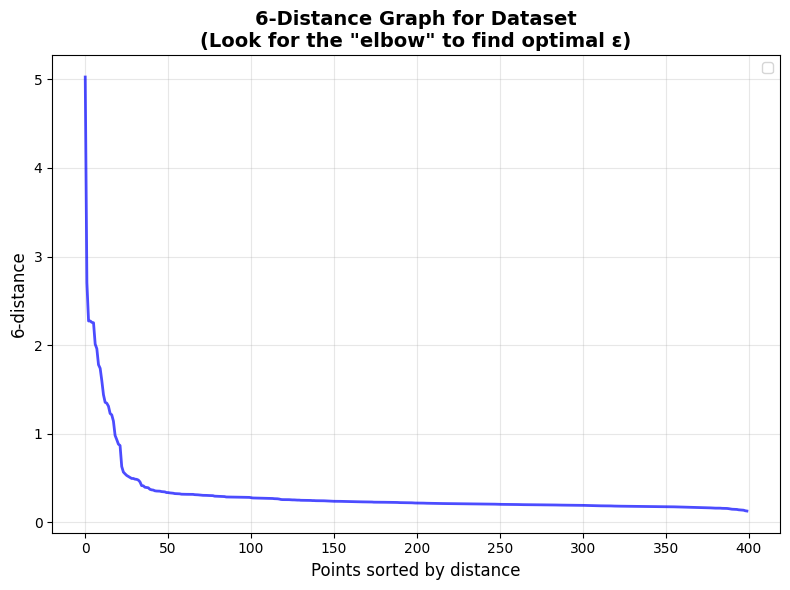

In [90]:
_ = plot_k_distance_graph(X, k=6)

As we can see there seems to be an elbow around 0.5, so let's choose values around 0.5 for epsilon.

- Next, let's visualize the clusters using PCA or UMAP. What can you conclude?

*Hint:* If you have not found an elbow in the previous task, use epsilon=0.5. For min_samples you can start with 7 (since we have 6 features).

In [91]:
# Student Code

In [92]:
# Solution

# Perform Dimensionality
# Option A: Fit PCA
#pca = PCA(n_components=2)
#X_reduced = pca.fit_transform(X)

# Option B: Fit UMAP
umap = UMAP(n_components=2, random_state=42)
X_reduced = umap.fit_transform(X)

In [93]:
# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

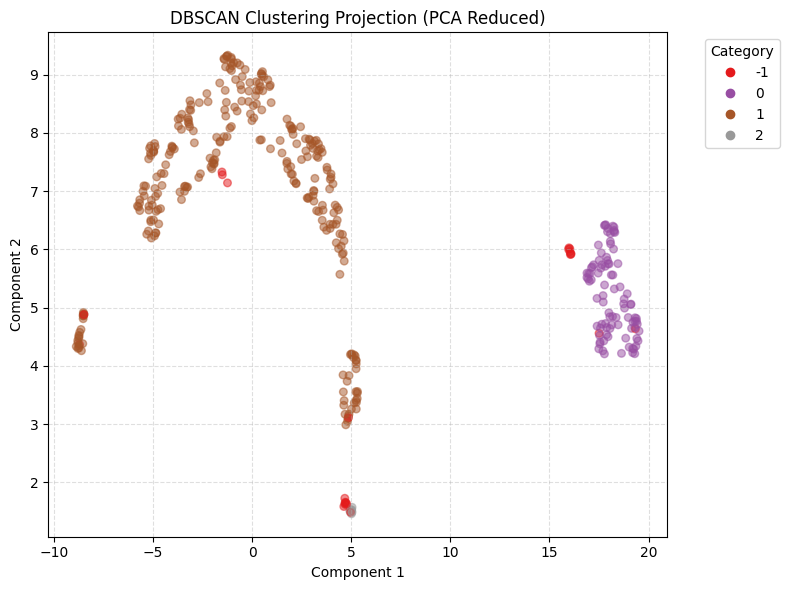

In [94]:
# TODO: Maybe a different function would be more helpful
plot_projection(X_reduced, dbscan_labels, title="DBSCAN Clustering Projection (PCA Reduced)",
                xlabel="Component 1", ylabel="Component 2")

- Nice now explore more parameter combinations and see how the clusters change. What do you observe? Are the chosen parameters optimal?

*Hint:* Use the `plot_dbscan_grid` function to visualize the clusters for different parameter combinations. You need to specify the data to cluster on and the one you want to plot.

In [95]:
# Student Code

In [96]:
# Solution
eps_values = [0.2, 0.4, 0.5, 0.6, 0.8]
min_samples_values = [2, 4, 5, 6, 8]

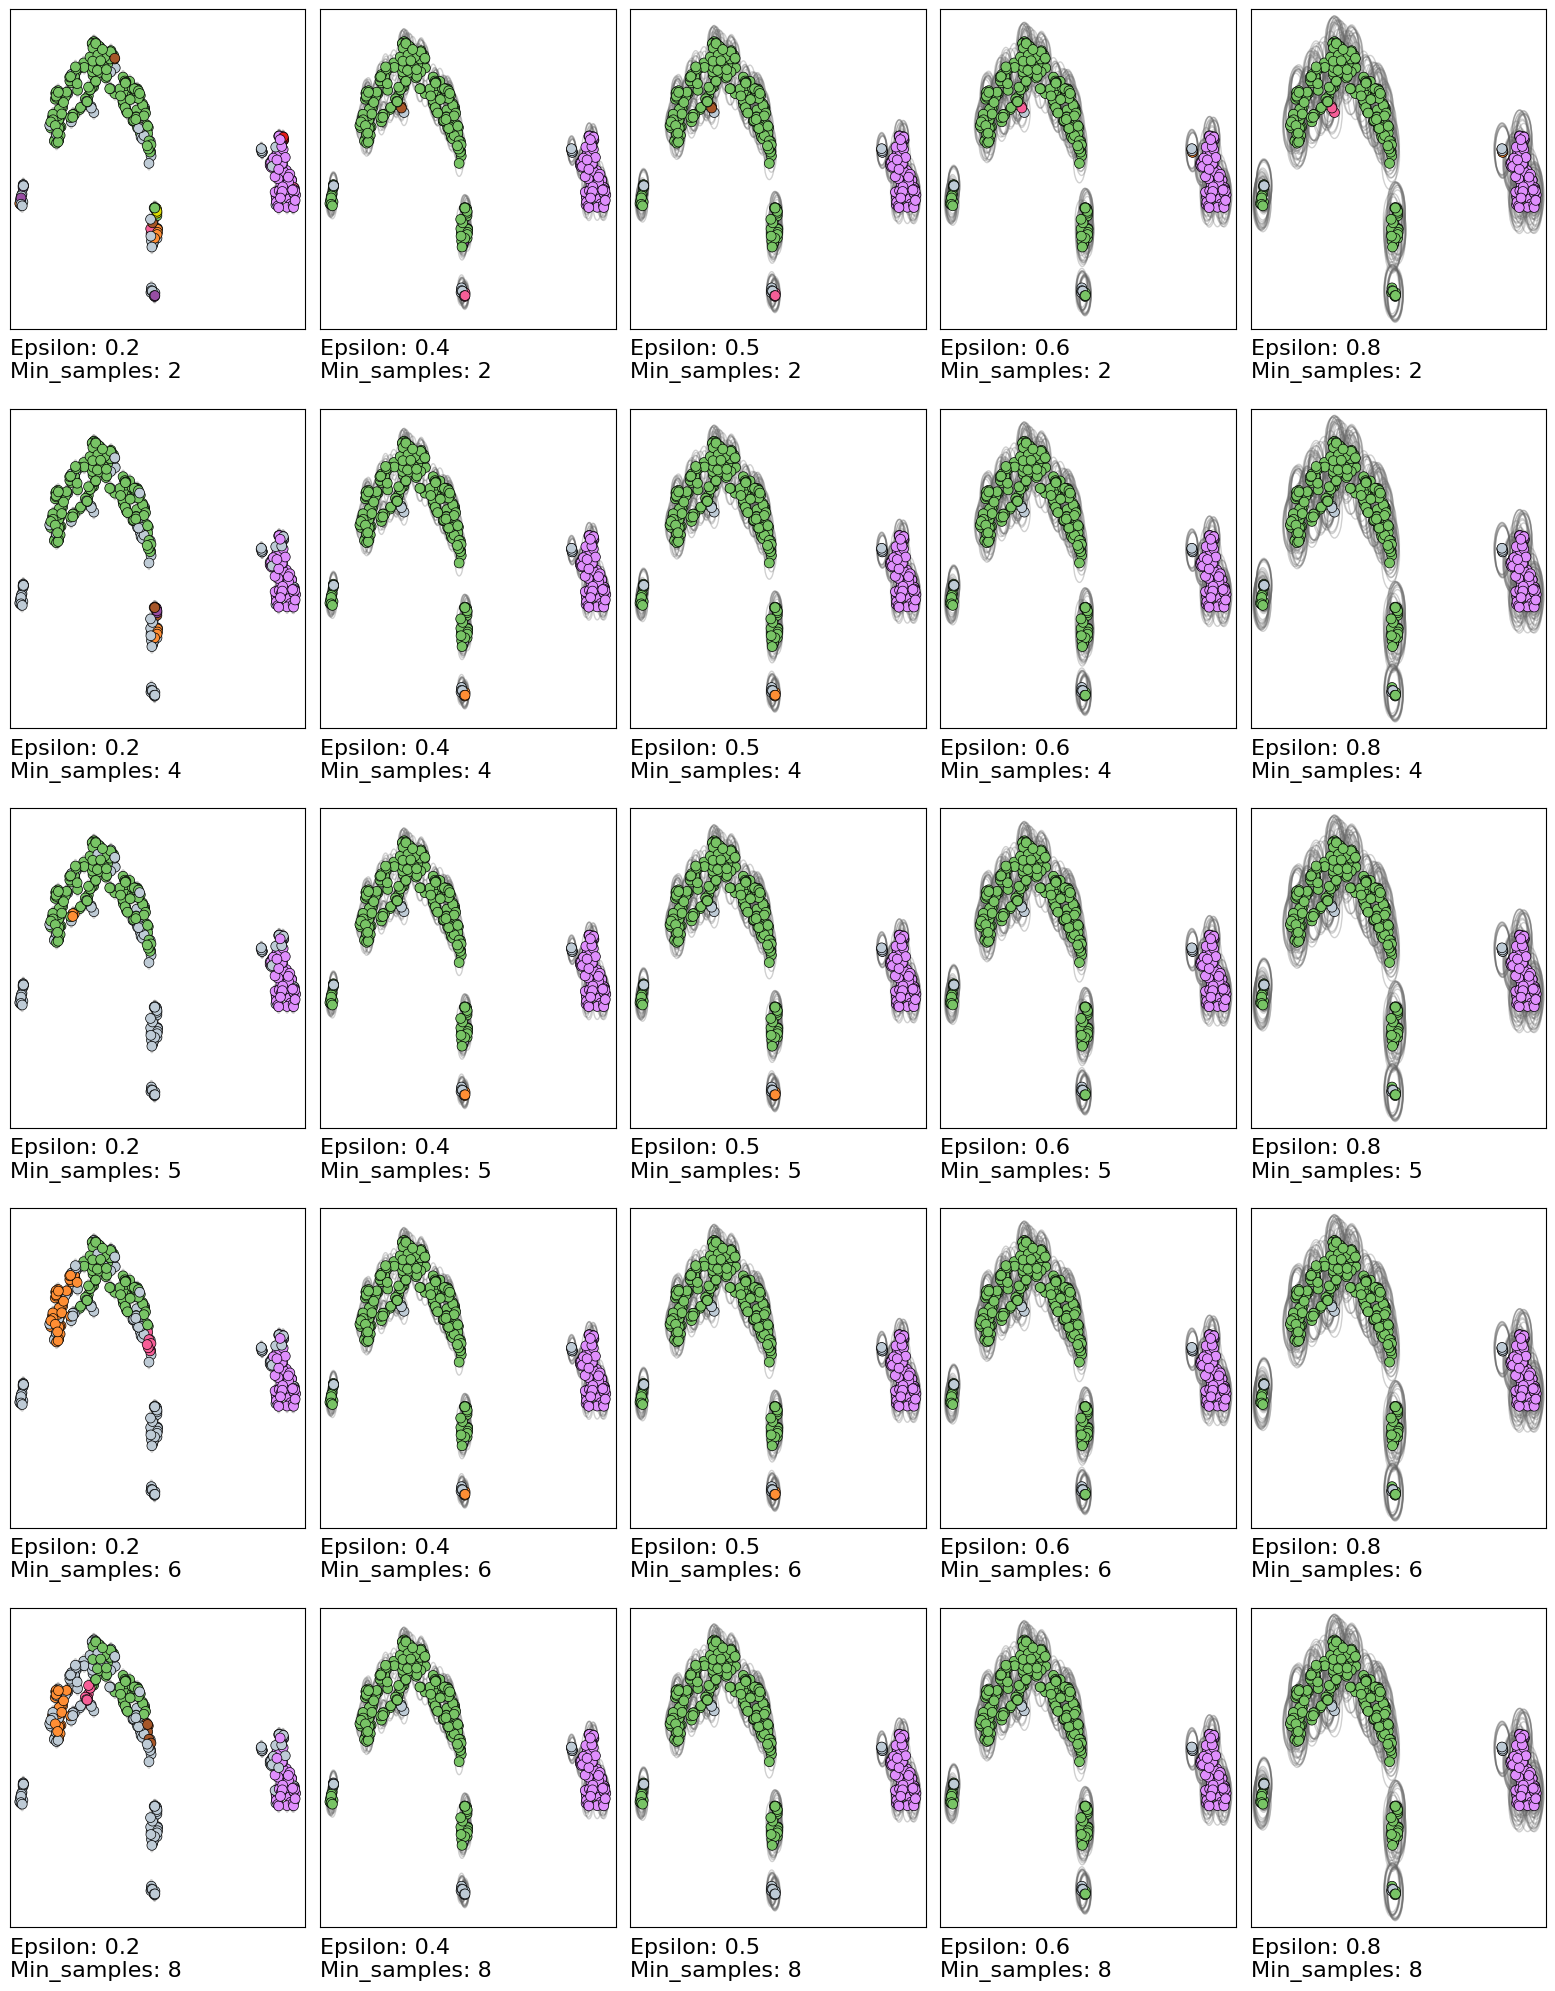

In [97]:
# plot dbscan grid
plot_dbscan_grid(X, eps_values, min_samples_values, X_reduced=X_reduced)

Maybe a bigger range? There's not much difference visible between the clustering, they all seem to find two main clusters present in the data.

- What are the mean values of features per clusters? Can you reasonable interpret this?

In [98]:
# Student Code

In [99]:
print_cluster_information_table(df, dbscan_labels)

Cluster Characteristics:
Numeric: mean values | Categorical: mode (count/total, %)
                        Cluster -1 Cluster 0 Cluster 1 Cluster 2
Inflammatory_Marker_CRP      44.45      0.05     26.82     69.61
Metabolic_Glucose           312.89    280.40    100.91    130.23
Cardiac_Troponin           -159.21   -215.90     18.88     60.30
Renal_Creatinine              2.49      4.36      1.20      1.51
Age_Related_Biomarker        75.38    106.39     55.93     71.22
Lipid_Cholesterol          1282.67   2788.84    199.20    498.65
Cluster Size                  n=23      n=91     n=279       n=7
